<center><h1>Hotspot Prediction and Analysis with Hypercolumns</h1></center>

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import copy
import crystallography as xtal
import numpy as np
import keras.backend as K
import pandas as pd
from scipy.misc import imrotate

import tensorflow as tf
from edward.models import Categorical, Normal, Empirical
import edward as ed
from keras.models import Model
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import AlphaDropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


Let's load up our data, sorting in row-major order using some Pandas

In [2]:
df = pd.read_csv('../data/micro9_9.csv')
df.sort_values(['x','y','z'],inplace=True)
microstructure = df.values.reshape((128,128,128,-1))
keys = list(df.columns.values)

We have a lot of available features here, let's see what they are.

In [3]:
print(dict(enumerate(keys)))

{0: 'AvgMisorientations', 1: 'AvgC_Axes_0', 2: 'AvgC_Axes_1', 3: 'AvgC_Axes_2', 4: 'EquivalentDiameters', 5: 'FeatureVolumes', 6: 'NumCells', 7: 'Neighborhoods', 8: 'NumNeighbors', 9: '100_IPF_0', 10: '100_IPF_1', 11: '100_IPF_2', 12: '001_IPF_0', 13: '001_IPF_1', 14: '001_IPF_2', 15: '010_IPF_0', 16: '010_IPF_1', 17: '010_IPF_2', 18: 'theta', 19: 'phi', 20: 'min_mis', 21: 'max_mis', 22: 'Schmid1', 23: 'Schmid2', 24: 'Schmid3', 25: 'Schmid4', 26: 'euler_1', 27: 'euler_2', 28: 'euler_3', 29: 'GBEuc', 30: 'QPEuc', 31: 'TJEuc', 32: 'KernelAvg', 33: 'x', 34: 'y', 35: 'z', 36: 'ngr', 37: 'ph', 38: 'fileID', 39: 'e11', 40: 'e22', 41: 'e33', 42: 'e23', 43: 'e13', 44: 'e12', 45: 'str11', 46: 'str22', 47: 'str33', 48: 'str23', 49: 'str13', 50: 'str12', 51: '-evm', 52: 'evs', 53: 'evShear', 54: 'EqVonMisesStress', 55: 'grain_hotspot', 56: 'EqVonMisesStrain', 57: 'hotspot'}


For our first attempt, let's try using only our orientation data. We're going to use 2D slices from our data, with the crystal orientations represented as quaternions (limited to the fundamental one). Let's do the fundamental zone calculations (using Will Lenthe's codebase available at github.com/wlenthe/crystallography), and visualize our data.

In [4]:
symmetry = xtal.Symmetry('hexagonal')
orientations = np.array(microstructure[:,:,:,26:29],dtype='float32')
fzqu = np.array(xtal.qu2do(symmetry.fzQu(xtal.eu2qu(orientations))),dtype='float32')
hotspots = np.array(microstructure[:,:,:,-1],dtype='float32')
vmstress = np.array(microstructure[:,:,:,54],dtype='float32')

<IPython.core.display.Javascript object>


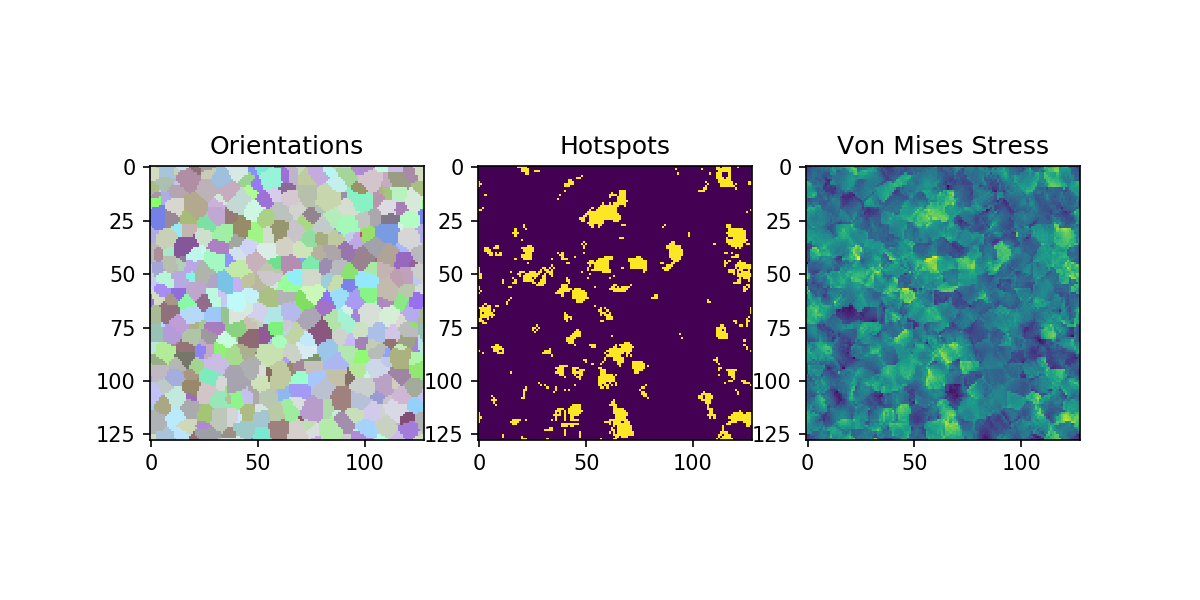

In [5]:
fig = plt.figure(figsize=(8,4))
a=fig.add_subplot(1,3,1)
plt.imshow(fzqu[0]+128) #increasing the values for visualization
a.set_title('Orientations')
a=fig.add_subplot(1,3,2)
plt.imshow(hotspots[0])
a.set_title('Hotspots')
a=fig.add_subplot(1,3,3)
plt.imshow(vmstress[0])
a.set_title('Von Mises Stress')

The human eye isn't very good at determining what's happening, so let's train some convolution kernels to do that! The first step is to create a data generator which samples 2D slices from our orientation data, rotates them around the tensile axis, and crops away the edges. We're going to use 80x80 crops, because 80 is divisible by 16 and that makes calculating the feature map locatoin

In [6]:
def generate_batch(fzqu,hotspots,vmstress):
    slice_index = np.random.randint(0,128)
    rotation = np.random.rand()*360
    rotated_fzqu = imrotate(fzqu[slice_index], rotation, interp='nearest')
    rotated_hotspots = imrotate(hotspots[slice_index], rotation, interp='nearest')
    rotated_vmstress = imrotate(vmstress[slice_index], rotation, interp='nearest')
    
    rotated_hotspots = np.expand_dims(rotated_hotspots,axis=-1)
    rotated_vmstress = np.expand_dims(rotated_vmstress,axis=-1)
    rotated = np.concatenate([rotated_fzqu,rotated_hotspots,rotated_vmstress],axis=-1)
    center = (int(rotated.shape[0]/2),int(rotated.shape[1]/2))
    cropped = rotated[center[0]-40:center[0]+40,center[1]-40:center[1]+40]
    expanded = np.expand_dims(cropped,axis=0)
    
    fz,hot,vm = expanded[:,:,:,:4],expanded[:,:,:,4],expanded[:,:,:,5]
    hot = np.expand_dims(hot,axis=-1)
    vm = np.expand_dims(vm,axis=-1)
    return fz,hot,vm

Now it's time to define our model.

In [7]:
''' Utility Functions for PixelNet'''
def upsample(input_list):
    output_list = []
    for i,x in enumerate(input_list):
        output = K.repeat_elements(K.repeat_elements(x,2**i,axis=1),2**i,axis=2)
        output_list.append(output)
    return K.concatenate(output_list,axis=3)

def upsample_shape(input_shapes):
    summation = int(np.sum([shape[3] for shape in input_shapes]))
    shape = input_shapes[0]
    return (shape[0],shape[1],shape[2],summation)
    
def im_flatten(x):
    return K.reshape(x,K.stack([-1,x.shape[1]*x.shape[2],x.shape[3]]))

def im_flatten_shape(shape):
    return (shape[0],shape[1]*shape[2],shape[3])

def expand_dims(x):
    return K.expand_dims(x,axis=0)

def expand_dims_shape(shape):
    return (1,shape[0],shape[1])

In [8]:
def orientation_net(optimizer):
    inputs = Input(shape=(80,80,4))
    fmap_list = []
    
    X = Conv2D(8,(3,3),padding='same',activation='relu')(inputs)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(8,(3,3),padding='same',activation='relu')(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(8,(3,3),padding='same',activation='relu')(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(8,(3,3),padding='same',activation='relu')(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(8,(3,3),padding='same',activation='relu')(X)
    fmap_list.append(X)
    
    hypercolumns = Lambda(upsample,output_shape=upsample_shape)(fmap_list)
    x = Reshape((6400,40))(hypercolumns)
    x = Dropout(0.25)(x)
    x = Dense(32,activation='relu')(x)
    x = Dropout(0.25)(x)
    hotspots = Dense(1,activation='sigmoid')(x)
    stress = Dense(1,activation=None)(x)
    model = Model(inputs=inputs,outputs=hotspots)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

Let's train our model with hyperparameter tuning done by 

In [26]:
def train_with_params(params,epochs):
        optimizer = Adam(lr=params[0],decay=params[1])
        loss = []
        batch_size = 16
        net = orientation_net(optimizer)
        for e in range(epochs):
            im_batch,hot_batch,vm_batch = generate_batch(fzqu,hotspots,vmstress)
            for _ in range(batch_size-1):
                im,hot,vm = generate_batch(fzqu,hotspots,vmstress)
                im_batch,hot_batch,vm_batch = np.vstack((im_batch,im)),\
                                              np.vstack((hot_batch,hot)),np.vstack((vm_batch,vm))
            hot_batch,vm_batch = hot_batch.reshape(batch_size,-1,1),vm_batch.reshape(batch_size,-1,1)
            ce = net.train_on_batch(im_batch,hot_batch)
            loss.append(ce)
        mean_loss = np.abs(np.mean(loss[int(epochs/2):]))
        print('Learning Rate: {}, Decay: {} -> Loss: {}'.format(params[0],params[1],mean_loss))
        return net,mean_loss

In [ ]:
with tf.device('/gpu:0'):
    initial_params = np.array([[1e-5,1e-2],[1e-6,1e-2],[1e-7,1e-2],
                               [1e-5,1e-3],[1e-6,1e-3],[1e-7,1e-3],
                               [1e-5,1e-4],[1e-6,1e-4],[1e-7,1e-4],
                               [1e-6,1e-5],[1e-7,1e-5],[1e-8,1e-5],
                               [1e-6,1e-6],[1e-7,1e-6],[1e-8,1e-6]])
    losses = []
    for params in initial_params:
        losses.append(train_with_params(params,300)[1])

Learning Rate: 1e-05, Decay: 0.01 -> Loss: 67.61507415771484
Learning Rate: 1e-06, Decay: 0.01 -> Loss: 106.2076644897461


In [ ]:
with tf.device('/gpu:0'):    
    T = len(initial_params) # number of samples
    beta = Normal(loc=tf.zeros(2), scale=tf.ones(2))
    z = Categorical(logits=tf.zeros(1))
    
    qbeta = Empirical(params=tf.Variable(tf.zeros([T, 2])))
    qz = Empirical(params=tf.Variable(tf.zeros([T])))
    
    x = np.array(initial_params)
    y = np.array(losses)
    inference = ed.HMC({beta: qbeta, z: qz}, data={x: y})